# 日経平均株価 日足 メディアン統計

In [1]:
import sys
path_up = '..'
if not path_up in sys.path:
    sys.path.append(path_up)

In [2]:
import datetime

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
import yfinance as yf

from funcs.technical import calc_robust_bollinger

In [3]:
code = 'N225'
symbol = '^%s' % code
ticker = yf.Ticker(symbol)

In [4]:
# 日足で過去 2 年分のデータを取得
df0 = ticker.history(period='10y', interval='1d')
 
# ローソク足のチャートには、そのうち過去 1 年分のみ使用する
dt_last = df0.index[len(df0) - 1]
tdelta_1y =  datetime.timedelta(days=365)
df = df0[df0.index >= dt_last - tdelta_1y]
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-04-22 00:00:00+09:00,37240.929688,37511.800781,37052.628906,37438.609375,119400000,0.0,0.0
2024-04-23 00:00:00+09:00,37797.058594,37817.781250,37397.269531,37552.160156,95900000,0.0,0.0
2024-04-24 00:00:00+09:00,37871.921875,38460.078125,37857.468750,38460.078125,121100000,0.0,0.0
2024-04-25 00:00:00+09:00,38065.910156,38129.531250,37604.230469,37628.480469,113900000,0.0,0.0
2024-04-26 00:00:00+09:00,37725.609375,38097.539062,37550.699219,37934.761719,124900000,0.0,0.0
...,...,...,...,...,...,...,...
2025-04-15 00:00:00+09:00,34349.011719,34459.000000,34266.308594,34267.539062,113800000,0.0,0.0
2025-04-16 00:00:00+09:00,34249.820312,34329.269531,33658.468750,33920.398438,115600000,0.0,0.0
2025-04-17 00:00:00+09:00,33987.011719,34379.128906,33931.531250,34377.601562,111200000,0.0,0.0


## Moving Median

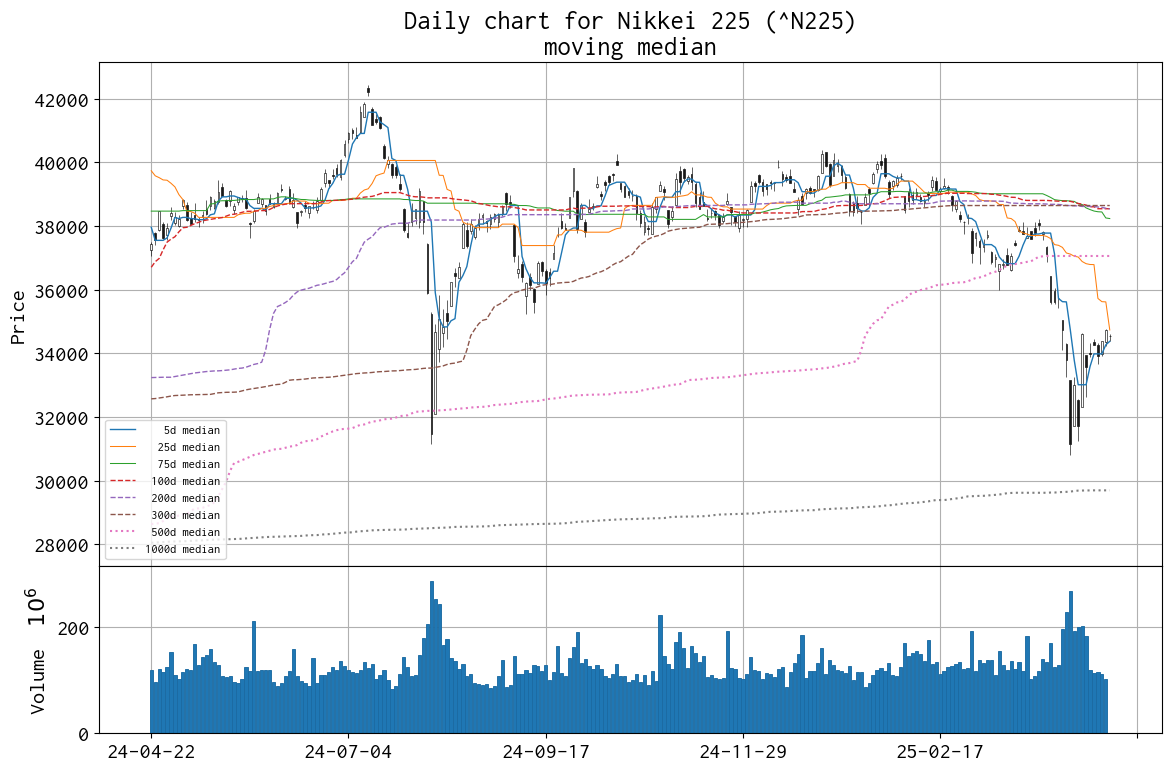

In [5]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig = plt.figure(figsize=(12, 8))
ax = dict()
n = 2
gs = fig.add_gridspec(
    n, 1,
    wspace=0.0, hspace=0.0,
    height_ratios=[3 if i == 0 else 1 for i in range(n)]
)
for i, axis in enumerate(gs.subplots(sharex='col')):
    ax[i] = axis
    ax[i].grid()

mm005 = df0['Close'].rolling(5).median()
mm025 = df0['Close'].rolling(25).median()
mm075 = df0['Close'].rolling(75).median()
mm100 = df0['Close'].rolling(100).median()
mm200 = df0['Close'].rolling(200).median()
mm300 = df0['Close'].rolling(300).median()
mm500 = df0['Close'].rolling(500).median()
mm1000 = df0['Close'].rolling(1000).median()

apds  = [
    mpf.make_addplot(mm005[df.index], width=1, label='   5d median', ax=ax[0]),
    mpf.make_addplot(mm025[df.index], width=0.75, label='  25d median', ax=ax[0]),
    mpf.make_addplot(mm075[df.index], width=0.75, label='  75d median', ax=ax[0]),
    mpf.make_addplot(mm100[df.index], width=1, linestyle='dashed', label=' 100d median', ax=ax[0]),
    mpf.make_addplot(mm200[df.index], width=1, linestyle='dashed', label=' 200d median', ax=ax[0]),
    mpf.make_addplot(mm300[df.index], width=1, linestyle='dashed', label=' 300d median', ax=ax[0]),
    mpf.make_addplot(mm500[df.index], width=1.5, linestyle='dotted', label=' 500d median', ax=ax[0]),
    mpf.make_addplot(mm1000[df.index], width=1.5, linestyle='dotted', label='1000d median', ax=ax[0]),
]   

mpf.plot(df, type='candle', style='default', volume=ax[1], datetime_format='%y-%m-%d', addplot=apds, xrotation=0, ax=ax[0])

ax[0].set_title('Daily chart for %s (%s)\nmoving median' %(ticker.info['longName'], symbol))
ax[0].legend(loc='lower left', fontsize=9)

plt.tight_layout()
plt.savefig('report_daily_chart_median_%s.png' % code)
plt.show()

In [6]:
df.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-04-18 00:00:00+09:00,34353.878906,34758.968750,34224.570312,34730.281250,102000000,0.0,0.0
2025-04-21 00:00:00+09:00,34556.230469,34610.601562,34388.828125,34560.121094,0,0.0,0.0


In [7]:
df.tail(2)['Close']

Date
2025-04-18 00:00:00+09:00    34730.281250
2025-04-21 00:00:00+09:00    34560.121094
Name: Close, dtype: float64

In [8]:
df.tail(2)['Close'].diff()

Date
2025-04-18 00:00:00+09:00           NaN
2025-04-21 00:00:00+09:00   -170.160156
Name: Close, dtype: float64

In [9]:
df['Close'].tail(1) - df['Open'].tail(1)

Date
2025-04-21 00:00:00+09:00    3.890625
dtype: float64

In [10]:
df['Close'].rolling(9).median().tail()

Date
2025-04-15 00:00:00+09:00    33780.578125
2025-04-16 00:00:00+09:00    33780.578125
2025-04-17 00:00:00+09:00    33920.398438
2025-04-18 00:00:00+09:00    33982.359375
2025-04-21 00:00:00+09:00    34267.539062
Name: Close, dtype: float64

In [11]:
df['Close'].rolling(13).median().tail()

Date
2025-04-15 00:00:00+09:00    34267.539062
2025-04-16 00:00:00+09:00    33982.359375
2025-04-17 00:00:00+09:00    33982.359375
2025-04-18 00:00:00+09:00    33982.359375
2025-04-21 00:00:00+09:00    33982.359375
Name: Close, dtype: float64

In [12]:
df['Close'].rolling(26).median().tail()

Date
2025-04-15 00:00:00+09:00    36791.570312
2025-04-16 00:00:00+09:00    36257.951172
2025-04-17 00:00:00+09:00    35675.175781
2025-04-18 00:00:00+09:00    35621.019531
2025-04-21 00:00:00+09:00    35176.744141
Name: Close, dtype: float64

In [13]:
df['Close'].rolling(52).median().tail()

Date
2025-04-15 00:00:00+09:00    37728.404297
2025-04-16 00:00:00+09:00    37690.994141
2025-04-17 00:00:00+09:00    37642.773438
2025-04-18 00:00:00+09:00    37513.363281
2025-04-21 00:00:00+09:00    37407.378906
Name: Close, dtype: float64

## Robust Bollinger's bands

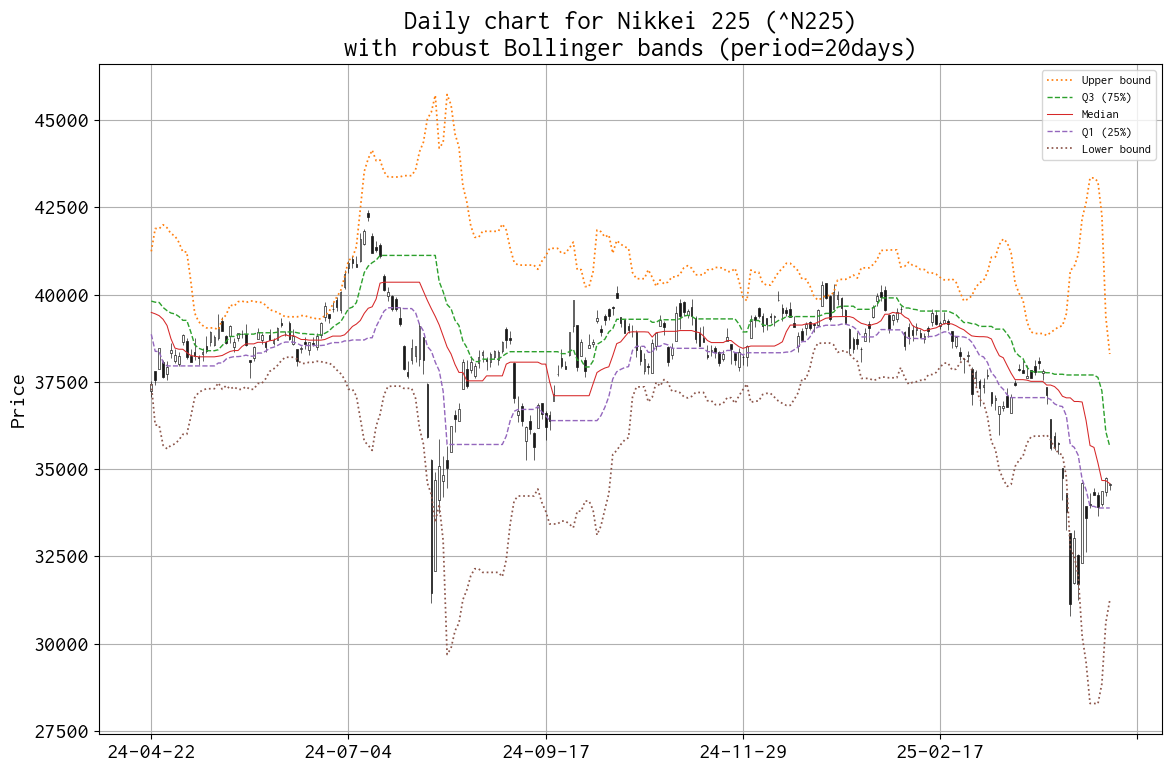

In [14]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig, ax = plt.subplots(figsize=(12, 8))

# Bollinger bands
period = 20
mv_median = df0['Close'].rolling(period).median()
mv_q1 = df0['Close'].rolling(period).quantile(.25)
mv_q3 = df0['Close'].rolling(period).quantile(.75)
mv_iqr = mv_q3 - mv_q1
mv_lower = mv_q1 - mv_iqr * 1.5
mv_upper = mv_q3 + mv_iqr * 1.5

apds  = [
    mpf.make_addplot(mv_upper[df.index], width=1.25, color='C1', linestyle='dotted', label='Upper bound', ax=ax),
    mpf.make_addplot(mv_q3[df.index], width=1, color='C2', linestyle='dashed', label='Q3 (75%)', ax=ax),
    mpf.make_addplot(mv_median[df.index], width=0.75, color='C3', label='Median', ax=ax),
    mpf.make_addplot(mv_q1[df.index], width=1, color='C4', linestyle='dashed', label='Q1 (25%)', ax=ax),
    mpf.make_addplot(mv_lower[df.index], width=1.25, color='C5', linestyle='dotted', label='Lower bound', ax=ax),
]   

mpf.plot(df, type='candle', style='default', addplot=apds, datetime_format='%y-%m-%d', xrotation=0, ax=ax)

ax.grid()
ax.legend(loc='best', fontsize=9)

try:
    ax.set_title('Daily chart for %s (%s)\nwith robust Bollinger bands (period=%ddays)' % (ticker.info['longName'], symbol, period))
except KeyError:
    ax.set_title('Daily chart for %s\nwith robust Bollinger bands (period=%ddays)' % (symbol, period))

plt.tight_layout()
plt.savefig('report_daily_chart_bollinger_robust_%s.png' % code)
plt.show()

## ヒストグラムと Q-Q プロット

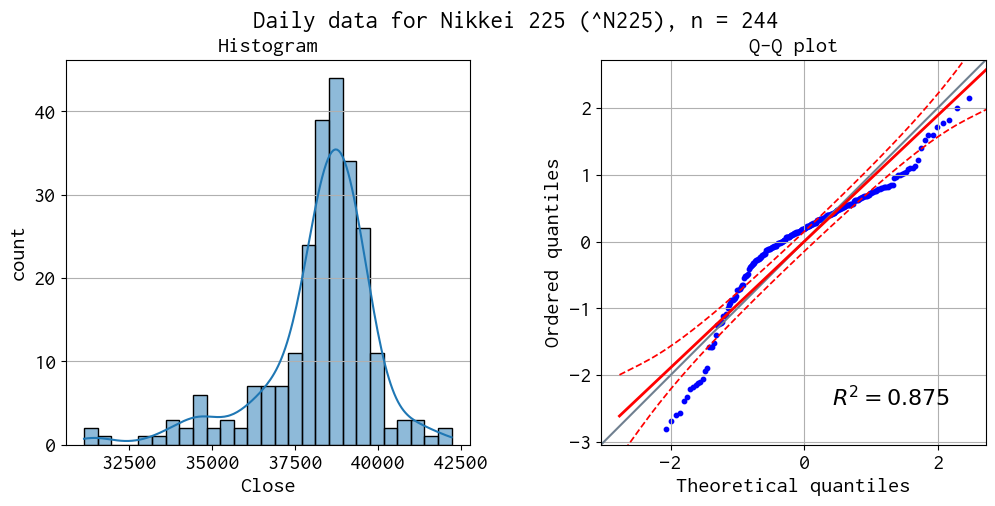

In [15]:
plt.rcParams['font.size'] = 16

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(
    df['Close'],
    kde=True,
    ax=axes[0]
)

# ヒストグラム
axes[0].set_xlabel("Close")
axes[0].set_ylabel("count")
axes[0].grid(axis = 'y')
axes[0].set_title('Histogram', fontsize=16)

# Q-Q プロット
pg.qqplot(df['Close'], s=10,  ax=axes[1])
axes[1].set_title('Q-Q plot', fontsize=16)
axes[1].grid()

plt.suptitle('Daily data for %s (%s), n = %d' % (ticker.info['longName'], symbol, len(df)), fontsize=18)
plt.subplots_adjust(wspace=0.3)
plt.savefig('report_daily_histogram_qqplot_%s.png' % code)
plt.show()